### <span style="color:blue;">Q1 • What is the distribution of the machines according to their CPU capacity?</span> 

#### 1. Data Processing and Strategy
We loaded the dataset, renamed the columns, and cleaned the data by removing missing CPU capacity values. We filtered only **ADD** events (`event_type = 0`) to focus on machines added to the cluster. Instead of binning, we grouped machines by their exact CPU capacities (`0.25`, `0.5`, `1.0`) and counted the number of machines for each value.


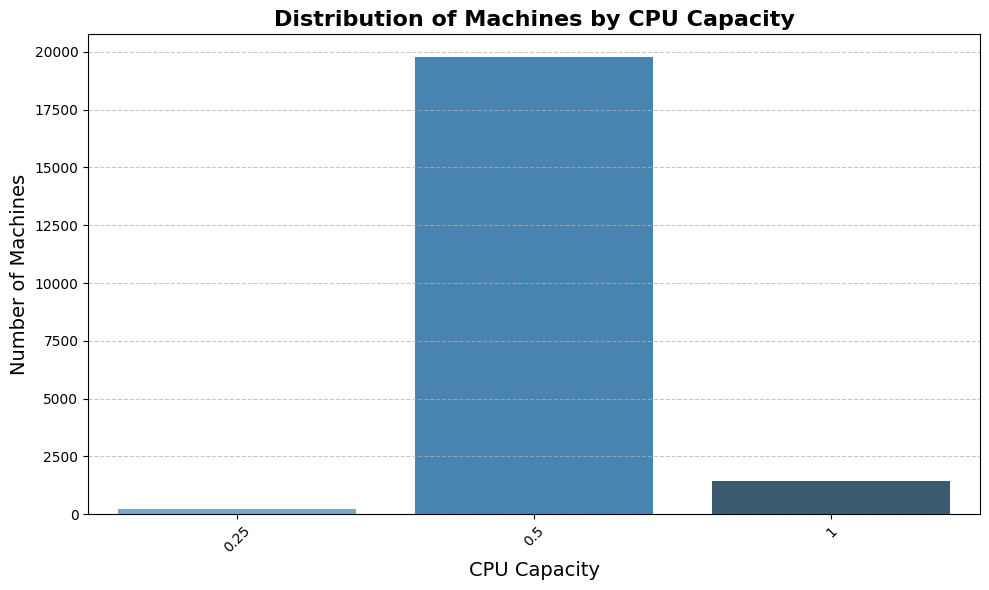

In [59]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create Spark session
spark = SparkSession.builder.master("local[*]").appName("Machine Events Analysis").getOrCreate()

# Load the CSV file and convert to RDD
file_path = "./spark-project/Spark-Data-Analysis/dataset/machine_events/part-00000-of-00001.csv.gz"
machine_events_rdd = spark.read.option("header", "false").csv(file_path).rdd

# Rename columns and clean data (RDD transformation)
machine_events_rdd = machine_events_rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5])) \
                                       .filter(lambda row: row[4] is not None and row[4] != "")  # Remove rows with missing cpu_capacity

# Filter rows where event_type is ADD (0)
added_machines_rdd = machine_events_rdd.filter(lambda row: int(row[2]) == 0)

# Group by CPU capacity and count machine occurrences
cpu_distribution_rdd = added_machines_rdd.map(lambda row: (row[4], 1)).reduceByKey(lambda a, b: a + b)

# Convert to Pandas DataFrame for visualization
df_cpu_distribution = pd.DataFrame(cpu_distribution_rdd.collect(), columns=["cpu_capacity", "machine_count"]).sort_values(by="cpu_capacity")

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="cpu_capacity", y="machine_count", hue="cpu_capacity", data=df_cpu_distribution, palette="Blues_d", dodge=False)
plt.xlabel("CPU Capacity", fontsize=14)
plt.ylabel("Number of Machines", fontsize=14)
plt.title("Distribution of Machines by CPU Capacity", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend([], [], frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



#### 2. Graph Analysis
The bar chart shows that most machines (~20,000) have a CPU capacity of `0.5`, indicating a standard mid-range configuration.  A smaller number of machines have a CPU capacity of `1.0`, likely used for high-performance tasks, while very few machines have a CPU capacity of `0.25`, suggesting lightweight configurations.

---

#### 3. Conclusion
This distribution highlights a cluster design optimized for balancing resource usage with task demands, with a focus on mid-range machines for most workloads and fewer high-performance machines for resource-intensive tasks.


### <span style="color:blue;">Q2 • What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?</span>

#### 1. Data Processing and Strategy
We processed both the job events and task events datasets to analyze how latency sensitivity, represented by `scheduling_class`, impacts the distribution of jobs and tasks. Each record was cleaned by removing rows where the `scheduling_class` was missing or empty to ensure all scheduling classes were represented. We grouped the data by `scheduling_class` to count the number of jobs and tasks in each class, converting the results to Pandas DataFrames for visual exploration.



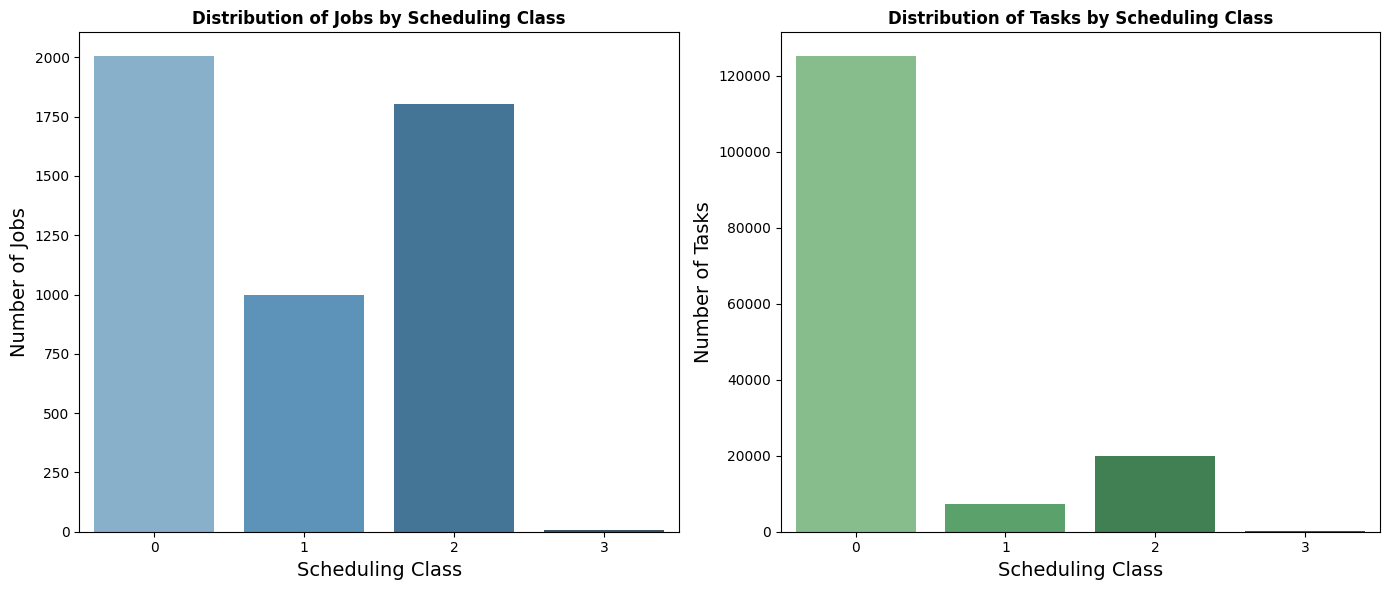

In [81]:
# Import necessary libraries
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the job events file and convert to RDD
file_path_jobs = "./spark-project/Spark-Data-Analysis/dataset/job_events/part-00400-of-00500.csv.gz"
job_events_rdd = spark.read.option("header", "false").csv(file_path_jobs).rdd

# Rename columns and filter RDD for non-null scheduling class
job_events_rdd = job_events_rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7])) \
                               .filter(lambda row: row[5] is not None and row[5] != "")

# Group by scheduling class and count jobs
job_distribution_rdd = job_events_rdd.map(lambda row: (row[5], 1)).reduceByKey(lambda a, b: a + b)

# Convert to Pandas DataFrame for visualization
df_job_distribution = pd.DataFrame(job_distribution_rdd.collect(), columns=["scheduling_class", "job_count"]).sort_values(by="scheduling_class")

# Load the task events file and convert to RDD
file_path_tasks = "./spark-project/Spark-Data-Analysis/dataset/task_events/part-00400-of-00500.csv.gz"
task_events_rdd = spark.read.option("header", "false").csv(file_path_tasks).rdd

# Rename columns and filter RDD for non-null scheduling class
task_events_rdd = task_events_rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12])) \
                                 .filter(lambda row: row[7] is not None and row[7] != "")

# Group by scheduling class and count tasks
task_distribution_rdd = task_events_rdd.map(lambda row: (row[7], 1)).reduceByKey(lambda a, b: a + b)

# Convert to Pandas DataFrame for visualization
df_task_distribution = pd.DataFrame(task_distribution_rdd.collect(), columns=["scheduling_class", "task_count"]).sort_values(by="scheduling_class")

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot job distribution
sns.barplot(ax=axes[0], x="scheduling_class", y="job_count", hue="scheduling_class", data=df_job_distribution, palette="Blues_d", dodge=False)
axes[0].set_xlabel("Scheduling Class", fontsize=14)
axes[0].set_ylabel("Number of Jobs", fontsize=14)
axes[0].set_title("Distribution of Jobs by Scheduling Class", fontsize=12, fontweight='bold')

# Plot task distribution
sns.barplot(ax=axes[1], x="scheduling_class", y="task_count", hue="scheduling_class", data=df_task_distribution, palette="Greens_d", dodge=False)
axes[1].set_xlabel("Scheduling Class", fontsize=14)
axes[1].set_ylabel("Number of Tasks", fontsize=14)
axes[1].set_title("Distribution of Tasks by Scheduling Class", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()



#### 2. Graph Analysis
The visualizations revealed that `scheduling_class 0` overwhelmingly contained the majority of jobs and tasks. Since `scheduling_class 0` represents non-production, non-business-critical workloads, this suggests that much of the system's workload consists of development tasks or analyses. Conversely, the higher scheduling classes (particularly `scheduling_class 3`, representing latency-sensitive, revenue-generating workloads) contained a far smaller proportion of jobs and tasks. This indicates that critical, user-facing tasks form a small fraction of the overall workload.

---

#### 3. Conclusion
We confirmed that most of the workload is allocated to less latency-sensitive tasks, such as development or non-essential analyses (`scheduling_class 0`). This could lead to resource contention if non-production tasks dominate machine usage. The minimal presence of `scheduling_class 3` suggests that latency-sensitive jobs are carefully managed, but further improvements could involve refining machine-local resource access policies or ensuring that priority settings effectively prioritize critical tasks. These insights highlight the need for a balance between supporting non-critical processes and ensuring resource availability for essential workloads.

### <span style="color:blue;">Q3 • What is the distribution of the number of jobs/tasks per scheduling class?</span>  

#### 1. Data Processing and Strategy
To analyze the eviction probability, we used the `task_events` dataset and filtered out tasks with missing `scheduling_class` values. We counted the total number of tasks and the number of evictions (`event_type = 2`) for each scheduling class. By joining these counts, we calculated the eviction probability as the ratio of evicted tasks to total tasks for each class. The results were converted to a Pandas DataFrame for visualization.



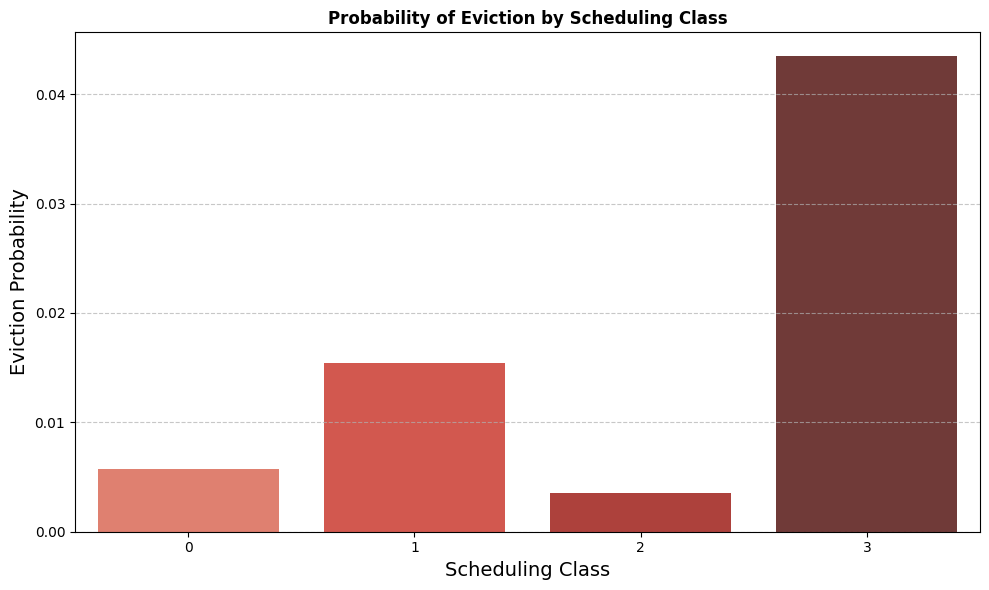

In [61]:
# Load the task events file and convert to RDD
file_path_tasks = "./spark-project/Spark-Data-Analysis/dataset/task_events/part-00400-of-00500.csv.gz"
task_events_rdd = spark.read.option("header", "false").csv(file_path_tasks).rdd

# Rename columns and filter RDD for non-null scheduling class
task_events_rdd = task_events_rdd.map(lambda row: (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12])) \
                                 .filter(lambda row: row[7] is not None and row[7] != "")

# Count total tasks per scheduling class
total_tasks_rdd = task_events_rdd.map(lambda row: (row[7], 1)).reduceByKey(lambda a, b: a + b)

# Count evictions (event_type == 2) per scheduling class
evictions_rdd = task_events_rdd.filter(lambda row: int(row[5]) == 2).map(lambda row: (row[7], 1)).reduceByKey(lambda a, b: a + b)

# Join total tasks and evictions RDD to calculate eviction probability
eviction_probability_rdd = total_tasks_rdd.join(evictions_rdd).map(lambda row: (row[0], row[1][1] / row[1][0]))

# Convert to Pandas DataFrame for visualization
df_eviction_probability = pd.DataFrame(eviction_probability_rdd.collect(), columns=["scheduling_class", "eviction_probability"]).sort_values(by="scheduling_class")

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="scheduling_class", y="eviction_probability", hue="scheduling_class", data=df_eviction_probability, palette="Reds_d", dodge=False)
plt.xlabel("Scheduling Class", fontsize=14)
plt.ylabel("Eviction Probability", fontsize=14)
plt.title("Probability of Eviction by Scheduling Class", fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



#### 2. Graph Analysis
The bar chart shows that tasks with **higher scheduling classes** (especially class `3`, indicating **high latency sensitivity**) have the highest eviction probability (4%). Conversely, tasks with **lower scheduling classes** (`0`, representing non-critical tasks) have a much **lower eviction probability** (1%). This suggests that although higher classes represent latency-sensitive tasks, they still face significant competition for resources, leading to frequent evictions.

---

#### 3. Conclusion
The analysis demonstrates that tasks with a **low scheduling class** (less latency-sensitive) generally have a **lower eviction probability**, while higher scheduling class tasks face **higher eviction risks**. This reflects the resource management strategy of the cluster, where tasks with **high scheduling classes** may still be evicted due to resource reallocation, despite their latency sensitivity.


### <span style="color:blue;">Q4 • Do tasks with a low scheduling class have a higher probability of being evicted?</span>  

#### 1. Data Processing and Strategy
We analyzed the **task_events** dataset to determine whether tasks from the same job are scheduled on the same machine or distributed across multiple machines.  
The steps included:
- Loading the dataset and renaming relevant fields (`job_id` and `machine_id`).
- Filtering the data to keep only rows where both `job_id` and `machine_id` were non-null to ensure completeness and accuracy.
- Grouping tasks by `job_id` and counting the number of distinct `machine_ids` for each job.
- Classifying jobs based on whether their tasks ran on a **single machine** (1 machine ID) or **multiple machines** (> 1 machine ID).
- Calculating the percentage of jobs with tasks running on a **single machine** versus **multiple machines**.


Jobs with tasks on a single machine: 1215
Jobs with tasks on multiple machines: 658


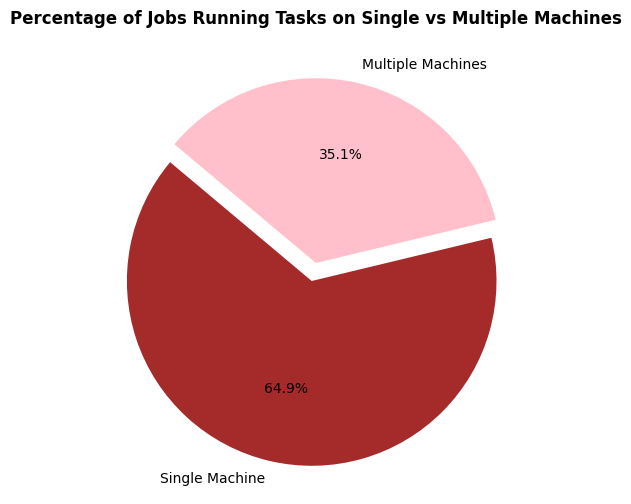

In [80]:
# Load the task events file and convert to RDD
file_path_tasks = "./spark-project/Spark-Data-Analysis/dataset/task_events/part-00400-of-00500.csv.gz"
task_events_rdd = spark.read.option("header", "false").csv(file_path_tasks).rdd

# Rename columns and filter RDD for non-null job_id and machine_id
task_events_rdd = task_events_rdd.map(lambda row: (row[2], row[4])).filter(lambda row: row[0] is not None and row[1] is not None)
# Group tasks by job_id and get unique machine_ids for each job
jobs_machine_rdd = task_events_rdd.groupByKey().mapValues(lambda machines: len(set(machines)))

# Count jobs where tasks ran on a single machine vs multiple machines
single_machine_jobs = jobs_machine_rdd.filter(lambda row: row[1] == 1).count()
multiple_machine_jobs = jobs_machine_rdd.filter(lambda row: row[1] > 1).count()
total_jobs = single_machine_jobs + multiple_machine_jobs

# Calculate percentages
percent_single_machine = (single_machine_jobs / total_jobs) * 100
percent_multiple_machine = (multiple_machine_jobs / total_jobs) * 100

# Display 
print(f"Jobs with tasks on a single machine: {single_machine_jobs:}")
print(f"Jobs with tasks on multiple machines: {multiple_machine_jobs:}")

# Visualization
import matplotlib.pyplot as plt

labels = ['Single Machine', 'Multiple Machines']
sizes = [percent_single_machine, percent_multiple_machine]
colors = ['brown', 'pink']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=(0.1, 0))
plt.title("Percentage of Jobs Running Tasks on Single vs Multiple Machines", fontsize=12, fontweight='bold')
plt.show()



#### 2. Graph Analysis
The pie chart shows that:
- **64.9%** of jobs had their tasks running on a **single machine**.
- **35.1%** of jobs had their tasks distributed across **multiple machines**.

This indicates that the majority of jobs run all their tasks on a single machine, potentially due to jobs with small resource requirements or constraints favoring local execution.  
However, a significant portion of jobs still utilizes multiple machines, which suggests parallelization for larger or more resource-intensive jobs.

---

#### 3. Conclusion
In general, most jobs have their tasks executed on a **single machine**, highlighting that the cluster favors local task execution when possible. However, approximately **one-third** of jobs distribute their tasks across **multiple machines**, likely for efficiency and to balance the workload.  This reflects a hybrid scheduling strategy that balances task locality with parallelism.


### <span style="color:blue;">Q5 • In general, do tasks from the same job run on the same machine?</span>  

#### 1. Data Processing and Strategy
To evaluate whether tasks that request more resources also consume more, we processed the **task_events** and **task_usage** datasets as follows:

- **task_events dataset:** Extracted `job_id`, `task_index`, `cpu_request`, and `memory_request` to represent the requested resources.
- **task_usage dataset:** Extracted `job_id`, `task_index`, `cpu_usage`, and `memory_usage` to represent the actual resource consumption.
- Rows with missing values for `job_id` and `task_index`, and rows with either missing or zero values for `cpu_request`, `memory_request`, `cpu_usage`, or `memory_usage` were filtered out to ensure accurate comparisons.
- The two datasets were joined on (`job_id`, `task_index`) to combine resource requests and consumption for each task.
- **Scatter plots** were generated to visualize the correlation between **CPU requests vs CPU usage** and **memory requests vs memory usage**.

Correlation between CPU request and CPU usage: -0.06
Correlation between memory request and memory usage: 0.35


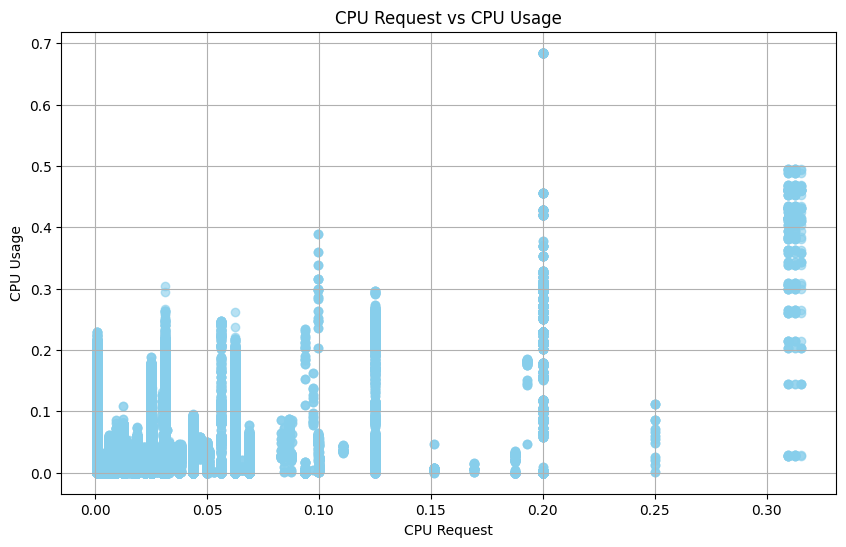

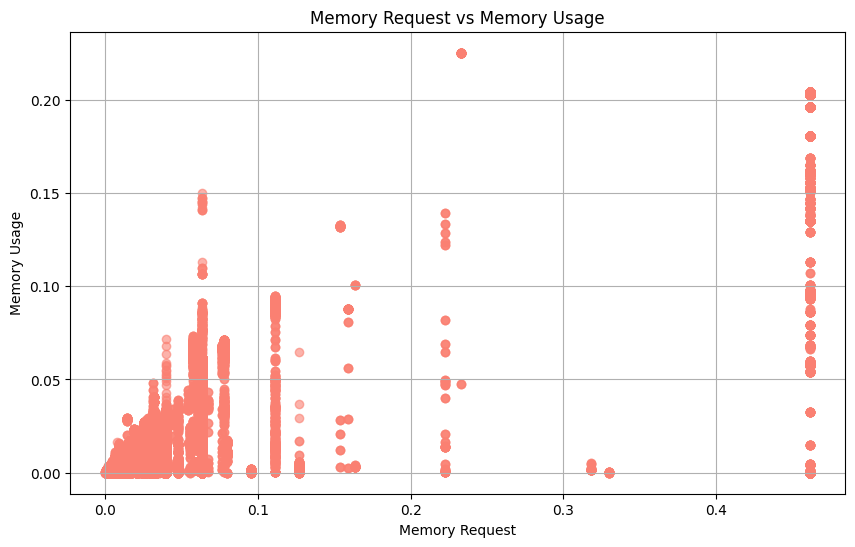

In [63]:
# Load and rename columns for task_events
file_path_events = "./spark-project/Spark-Data-Analysis/dataset/task_events/part-00400-of-00500.csv.gz"
task_events_rdd = spark.read.option("header", "false").csv(file_path_events).rdd
task_events_rdd = task_events_rdd.map(lambda row: (row[2], row[3], row[9], row[10]))  # (job_id, task_index, cpu_request, memory_request)

# Filter out rows where job_id, task_index, cpu_request, or memory_request is missing or zero
task_events_rdd = task_events_rdd.filter(lambda row: row[0] is not None and row[1] is not None and row[2] is not None and row[3] is not None and float(row[2]) > 0 and float(row[3]) > 0)

# Convert fields to float after filtering
task_events_rdd = task_events_rdd.map(lambda row: (row[0], row[1], float(row[2]), float(row[3])))

# Load and rename columns for task_usage
file_path_usage = "./spark-project/Spark-Data-Analysis/dataset/task_usage/part-00400-of-00500.csv.gz"
task_usage_rdd = spark.read.option("header", "false").csv(file_path_usage).rdd
task_usage_rdd = task_usage_rdd.map(lambda row: (row[2], row[3], row[5], row[6]))  # (job_id, task_index, cpu_usage, memory_usage)

# Filter out rows where job_id, task_index, cpu_usage, or memory_usage is missing or zero
task_usage_rdd = task_usage_rdd.filter(lambda row: row[0] is not None and row[1] is not None and row[2] is not None and row[3] is not None and float(row[2]) > 0 and float(row[3]) > 0)

# Convert fields to float after filtering
task_usage_rdd = task_usage_rdd.map(lambda row: (row[0], row[1], float(row[2]), float(row[3])))

# Join task_events and task_usage on (job_id, task_index)
combined_rdd = task_events_rdd.map(lambda x: ((x[0], x[1]), (x[2], x[3]))).join(
    task_usage_rdd.map(lambda x: ((x[0], x[1]), (x[2], x[3]))))

# Create final RDD with (cpu_request, memory_request, cpu_usage, memory_usage)
resource_comparison_rdd = combined_rdd.map(lambda row: (row[1][0][0], row[1][0][1], row[1][1][0], row[1][1][1]))  # (cpu_request, memory_request, cpu_usage, memory_usage)

# Convert to Pandas DataFrame for visualization
df_resource_comparison = pd.DataFrame(resource_comparison_rdd.collect(), columns=["cpu_request", "memory_request", "cpu_usage", "memory_usage"])

# Calculate correlation for CPU request vs CPU usage
cpu_correlation = df_resource_comparison["cpu_request"].corr(df_resource_comparison["cpu_usage"])
print(f"Correlation between CPU request and CPU usage: {cpu_correlation:.2f}")

# Calculate correlation for memory request vs memory usage
memory_correlation = df_resource_comparison["memory_request"].corr(df_resource_comparison["memory_usage"])
print(f"Correlation between memory request and memory usage: {memory_correlation:.2f}")


# Visualization: Scatter plots for CPU and Memory
plt.figure(figsize=(10, 6))
plt.scatter(df_resource_comparison["cpu_request"], df_resource_comparison["cpu_usage"], alpha=0.6, color='skyblue', label="CPU")
plt.xlabel("CPU Request")
plt.ylabel("CPU Usage")
plt.title("CPU Request vs CPU Usage")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_resource_comparison["memory_request"], df_resource_comparison["memory_usage"], alpha=0.6, color='salmon', label="Memory")
plt.xlabel("Memory Request")
plt.ylabel("Memory Usage")
plt.title("Memory Request vs Memory Usage")
plt.grid(True)
plt.show()



#### 2. Graph Analysis

##### **CPU Request vs CPU Usage:**
- The correlation coefficient is **-0.06**, indicating an almost non-existent or weak **negative correlation** between CPU requests and CPU usage.
- The scatter plot confirms this, showing that many tasks request significant CPU but consume very little, indicating **severe over-provisioning**.

##### **Memory Request vs Memory Usage:**
- The correlation coefficient is **0.35**, showing a **weak positive correlation** between memory requests and actual usage.
- The scatter plot shows that tasks requesting **low memory** often consume close to zero, but as memory requests increase, the actual consumption tends to increase as well, though with some variance.

---

#### 3. Conclusion
The results suggest that **CPU requests** are poorly aligned with actual CPU usage, highlighting inefficiencies and significant **over-provisioning**. **Memory requests** show a slightly better alignment, but there is still room for improvement.  
These findings suggest that there is a need for more accurate **resource request predictions**, particularly for CPU, to improve **cluster efficiency** and reduce **wasted resources**.


### <span style="color:blue;">Q6 • Are the tasks that request the most resources the ones that consume the most resources?</span> 

#### 1. Data Processing and Strategy

##### **Task Events Data:**
- We loaded the **task events** dataset and filtered the relevant columns: `machine_id` and `event_type`. Only rows with **non-null `machine_id`** and **`event_type`** were retained.
- We specifically filtered events where `event_type = 2` (indicating **task eviction events**).
- We counted the number of eviction events for each `machine_id`.

##### **Task Usage Data:**
- We loaded the **task usage** dataset and selected the relevant columns: `machine_id`, `timestamp`, `cpu_usage`, and `memory_usage`.
- Only records with **non-null `machine_id`** and **`timestamp`** were included.
- CPU and memory usage values across all tasks running on the same machine at the same time were **summed** to get the **total resource usage** per timestamp for each machine.
- For each `machine_id`, the **maximum CPU** and **memory usage** over all timestamps were determined to represent the **peak resource usage** for that machine.

##### **Joining Data:**
- The eviction counts were joined with the **maximum resource usage** for each machine using the `machine_id` as the key.


Correlation between max CPU usage and task evictions: 0.27
Correlation between max memory usage and task evictions: 0.04


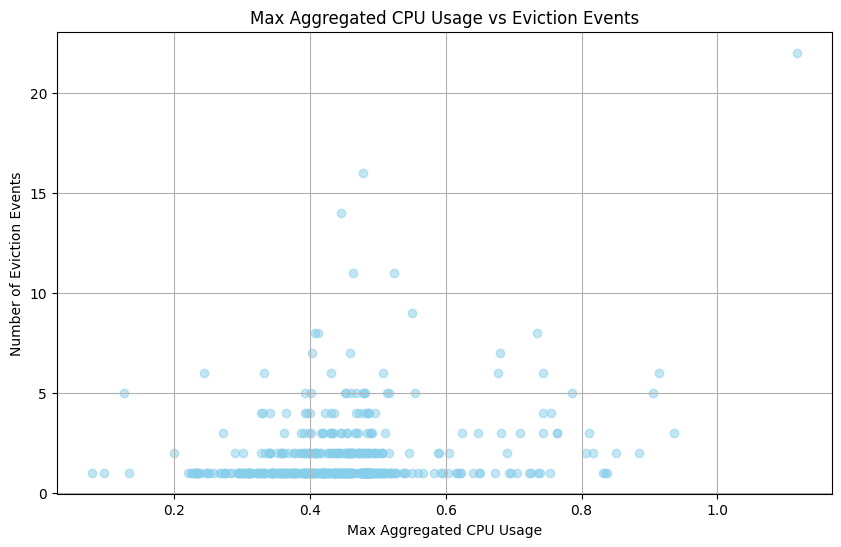

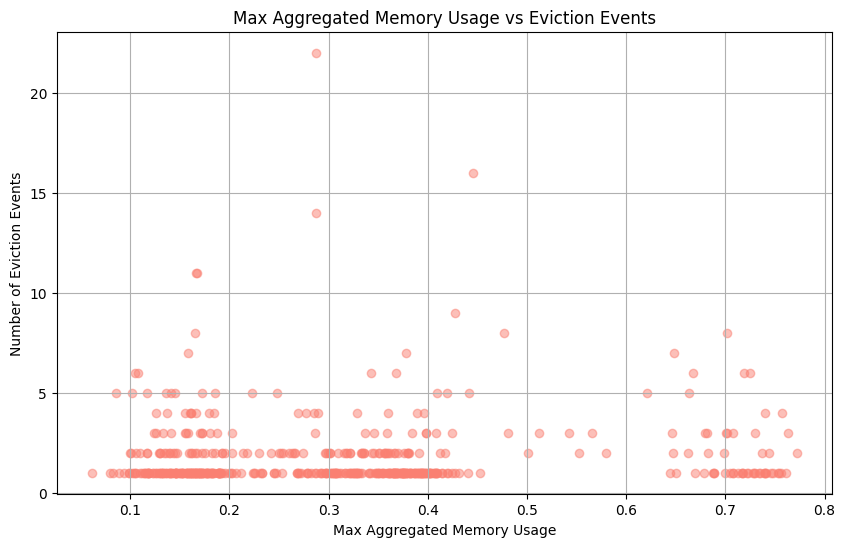

In [64]:
# Load data directly without needing to split
task_events_rdd = spark.read.option("header", "false").csv("./spark-project/Spark-Data-Analysis/dataset/task_events/part-00400-of-00500.csv.gz").rdd
task_usage_rdd = spark.read.option("header", "false").csv("./spark-project/Spark-Data-Analysis/dataset/task_usage/part-00400-of-00500.csv.gz").rdd

# Extract relevant columns for task events and filter for non-null machine_id and event_type
task_events_relevant_rdd = task_events_rdd.map(lambda row: (row[4], row[5]))  # (machine_id, (event_type))
task_events_relevant_rdd = task_events_relevant_rdd.filter(lambda x: x[0] is not None and x[1] is not None)

# Filter for eviction events (event_type == 2)
eviction_events_rdd = task_events_relevant_rdd.filter(lambda x: x[1] == '2').map(lambda x: (x[0], 1))  # (machine_id, 1)

# Count evictions per machine
eviction_count_per_machine = eviction_events_rdd.reduceByKey(lambda a, b: a + b)

# Extract relevant columns for task usage and filter for non-null machine_id and timestamp
task_usage_relevant_rdd = task_usage_rdd.map(lambda row: ((row[4], row[0]), (float(row[5] or 0), float(row[6] or 0))))  # ((machine_id, time), (cpu_usage, memory_usage))
task_usage_relevant_rdd = task_usage_relevant_rdd.filter(lambda x: x[0][0] is not None and x[0][1] is not None)

# Sum CPU and memory usage across tasks running at the same instant on a machine
aggregated_usage_per_machine_time = task_usage_relevant_rdd.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  # Sum CPU and memory usage

# Get the max CPU and memory usage per machine across all timestamps
max_resource_usage_per_machine = aggregated_usage_per_machine_time.map(lambda x: (x[0][0], x[1])) \
    .reduceByKey(lambda a, b: (max(a[0], b[0]), max(a[1], b[1])))  # (machine_id, (max_cpu_usage, max_memory_usage))

# Join eviction counts and max resource usage on machine_id
combined_rdd = eviction_count_per_machine.join(max_resource_usage_per_machine)  # (machine_id, (eviction_count, (max_cpu, max_memory)))

# Convert to Pandas DataFrame for analysis
df_combined = pd.DataFrame(combined_rdd.map(lambda row: (row[0], row[1][0], row[1][1][0], row[1][1][1])).collect(),
                           columns=["machine_id", "eviction_count", "max_cpu_usage", "max_memory_usage"])

# Calculate correlation
cpu_eviction_correlation = df_combined["eviction_count"].corr(df_combined["max_cpu_usage"])
memory_eviction_correlation = df_combined["eviction_count"].corr(df_combined["max_memory_usage"])

# Display correlation results
print(f"Correlation between max CPU usage and task evictions: {cpu_eviction_correlation:.2f}")
print(f"Correlation between max memory usage and task evictions: {memory_eviction_correlation:.2f}")

# Visualization: Scatter plots
plt.figure(figsize=(10, 6))
plt.scatter(df_combined["max_cpu_usage"], df_combined["eviction_count"], alpha=0.5, color='skyblue')
plt.title('Max Aggregated CPU Usage vs Eviction Events')
plt.xlabel('Max Aggregated CPU Usage')
plt.ylabel('Number of Eviction Events')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df_combined["max_memory_usage"], df_combined["eviction_count"], alpha=0.5, color='salmon')
plt.title('Max Aggregated Memory Usage vs Eviction Events')
plt.xlabel('Max Aggregated Memory Usage')
plt.ylabel('Number of Eviction Events')
plt.grid(True)
plt.show()



#### 2. Graph Analysis

##### **Scatter Plot 1: Max CPU Usage vs. Eviction Events**
- The scatter plot shows the relationship between the **maximum aggregated CPU usage** and the **number of eviction events**.
- Although the data points seem scattered, we can observe clusters of machines with **higher CPU usage** that experience **multiple eviction events**.
- **Correlation:** The correlation coefficient between **max CPU usage** and **eviction events** was **0.27**, indicating a **weak but positive correlation**.

##### **Scatter Plot 2: Max Memory Usage vs. Eviction Events**
- The second scatter plot illustrates the relationship between the **maximum memory usage** and the **eviction events**.
- The points are more uniformly distributed across the plot, suggesting that **memory usage** does not strongly influence evictions.
- **Correlation:** The correlation coefficient between **max memory usage** and **eviction events** was **0.04**, indicating **almost no correlation** between memory usage and task evictions.

---

### 3. Conclusion
- The correlation analysis suggests that there is a **weak positive correlation** between **high CPU usage** and **eviction events**, implying that some evictions may be triggered by **resource contention** due to CPU overload.
- Conversely, **memory usage** appears to have a **negligible effect** on eviction events, indicating that tasks are less likely to be evicted due to **memory pressure**.
- Further investigation into **scheduling policies** and **resource limits** might provide more insights into the root causes of evictions.

The results indicate that **CPU resource peaks** are a more likely contributor to evictions than memory, but the overall correlations are not strong enough to make **definitive claims**.


### <span style="color:blue;">Q7 • Can we observe correlations between peaks of high resource consumption on some machines and task eviction events?</span>  

#### 1. Data Processing and Strategy

To compute the percentage of **computational power lost** due to machine downtimes and visualize the results.

##### **Steps Taken:**

- **Data Loading and Preprocessing:**
    - The **machine events** dataset (`part-00000-of-00001.csv.gz`) was loaded using **PySpark**.
    - Rows with missing values in the **timestamp**, **machine ID**, and **event type** were filtered out.

- **Time Conversion:**

    - **Timestamps** were converted from **microseconds** to **seconds** for better readability and calculations.

- **Grouping and Downtime Identification:**

    - Events were grouped by **machine ID**.
    - For each machine, pairs of **REMOVE (offline)** and **ADD (online)** events were identified to calculate the **downtime periods**.

- **Computational Power Loss Calculation:**

    - For each downtime, the **CPU capacity** was multiplied by the **duration (in hours)** to calculate the lost **computational power (CPU-hours)**.
    - The **average CPU capacity** per machine was used to account for any fluctuations in CPU assignment over time.
    - The **total observation period** (start to end time across all machines) was used to compute the **total possible computational power**.


Total lost computational power (CPU-hours): 22298.12
Total available computational power (CPU-hours): 4625229.69
Percentage of lost computational power: 0.48%


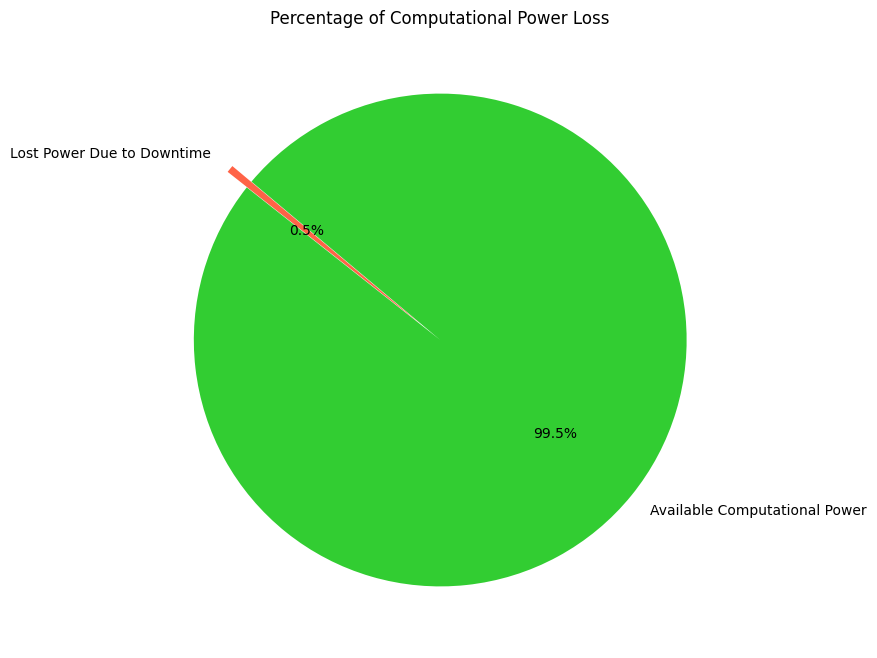

In [65]:
from pyspark.sql import Row
import matplotlib.pyplot as plt

# File path for machine events dataset
dataset_path = "./spark-project/Spark-Data-Analysis/dataset/machine_events/part-00000-of-00001.csv.gz"
microseconds_to_seconds = 1e6  # Convert microseconds to seconds

# Load machine events as an RDD
machine_events_rdd = spark.read.option("header", "false").csv(dataset_path).rdd

# Clean and parse the RDD, ignoring null or missing values
machine_events_rdd = machine_events_rdd.filter(lambda record: record[0] is not None and record[1] is not None and record[2] is not None)
machine_events_rdd = machine_events_rdd.map(lambda record: Row(
    time=int(record[0]) / microseconds_to_seconds,
    machine_id=int(record[1]),
    event=int(record[2]),
    cpu_capacity=float(record[4].strip()) if record[4] and record[4].strip() != '' else 0.0,
))

# Group events by machine_id
grouped_events_by_machine = machine_events_rdd.groupBy(lambda event: event.machine_id)

# Compute downtime and lost computational power inline
downtime_and_power_loss_rdd = grouped_events_by_machine.mapValues(lambda events: sorted(events, key=lambda e: e.time)) \
    .flatMapValues(lambda events: [(events[i].cpu_capacity, events[i + 1].time - events[i].time)
                                   for i in range(len(events) - 1)
                                   if events[i].event == 1 and events[i + 1].event == 0])  # Remove-Add pairs

# Sum total lost computational power and offline time
total_lost_power = downtime_and_power_loss_rdd.map(lambda x: x[1][0] * (x[1][1] / 3600)).sum()  # Convert seconds to hours

# Determine observation time (min and max timestamps)
start_time = machine_events_rdd.map(lambda x: x.time).min()
end_time = machine_events_rdd.map(lambda x: x.time).max()
total_observation_time = (end_time - start_time) / 3600  # Convert to hours

# Get average CPU capacity per machine
average_cpu_capacity_rdd = machine_events_rdd.filter(lambda x: x.event == 0) \
    .map(lambda x: (x.machine_id, (x.cpu_capacity, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda x: x[0] / x[1])  # Calculate average CPU capacity for each machine

# Sum of average CPU capacities across all machines
total_cpu_capacity = average_cpu_capacity_rdd.map(lambda x: x[1]).sum()

# Compute the total available computational power
total_possible_computation = total_observation_time * total_cpu_capacity

# Calculate percentage of power loss
percentage_power_loss = (total_lost_power / total_possible_computation) * 100

# Output results
print(f"Total lost computational power (CPU-hours): {total_lost_power:.2f}")
print(f"Total available computational power (CPU-hours): {total_possible_computation:.2f}")
print(f"Percentage of lost computational power: {percentage_power_loss:.2f}%")

# Visualization: 
chart_labels = ['Lost Power Due to Downtime', 'Available Computational Power']
chart_sizes = [total_lost_power, total_possible_computation - total_lost_power]
chart_colors = ['tomato', 'limegreen']
explode_sections = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(chart_sizes, labels=chart_labels, colors=chart_colors, autopct='%1.1f%%', startangle=140, explode=explode_sections)
plt.title("Percentage of Computational Power Loss")
plt.show()



#### 2. Graph Analysis

The pie chart visually represents the breakdown of available and lost computational power:
- **Lost Power (Red, 0.48%)**: Represents the **CPU-hours lost** due to downtimes.
- **Available Power (Green, 99.52%)**: Represents the **CPU-hours** that were **available** during the observation period.

This demonstrates that only a **small fraction** of computational power was lost, indicating that **downtimes had a minimal impact**.

---

#### 3. Conclusion

The results show that only **0.48%** of the computational power was lost:

- **Total lost computational power**: `22,298.12` CPU-hours
- **Total available computational power**: `4,625,229.69` CPU-hours
- **Percentage of power lost**: **0.48%**

The low percentage of lost computational power suggests that the system maintains a **high level of uptime** and **resource availability**. However, further monitoring can help identify **patterns in downtime events** and ensure **continued improvement**.


### <span style="color:blue;">Q8 • What is the average scheduling latency for jobs, and how does it vary over time?</span> 

#### 1. Data Processing and Strategy

The goal of this analysis is to measure and visualize the **time taken between SUBMIT (0) and SCHEDULE (1) events** for jobs.  
The dataset contains job event records, and the following steps were performed:

##### **Steps:**
- **Loaded** job event data as an **RDD** and filtered for relevant events.
- Extracted **job submission** and **scheduling events**, and joined them by `job_id` to compute **scheduling latency**.
- Calculated the **average scheduling latency** across all jobs.
- Grouped the job events into **1-hour sliding time windows** to track average scheduling latency trends over time.
- Identified jobs with **unusually high scheduling latencies** based on a threshold of **2x the average scheduling latency**.


Average scheduling latency (seconds): 3.71


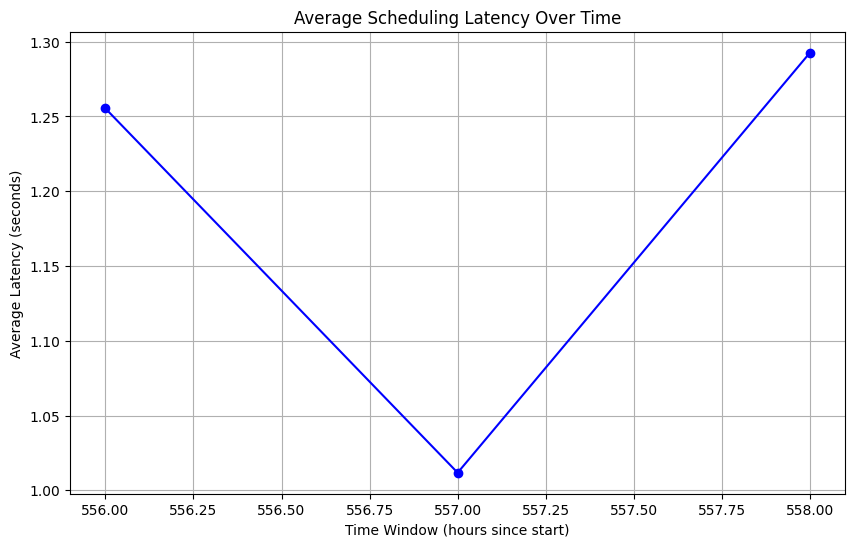

Jobs with scheduling latency > 7.43 seconds:
Job ID: 6439592366, Latency: 8.85 seconds
Job ID: 6439592550, Latency: 8.83 seconds
Job ID: 6439516428, Latency: 3597.00 seconds
Job ID: 6439570274, Latency: 8.86 seconds
Job ID: 6439592345, Latency: 8.86 seconds
Job ID: 6439593442, Latency: 8.84 seconds
Job ID: 6439593455, Latency: 8.83 seconds
Job ID: 6439593518, Latency: 8.82 seconds
Job ID: 6439593591, Latency: 8.82 seconds


In [70]:
from pyspark.sql import Row
import matplotlib.pyplot as plt

# File path for job events dataset
job_events_path = "./spark-project/Spark-Data-Analysis/dataset/job_events/part-00400-of-00500.csv.gz"
microseconds_to_seconds = 1e6  # Convert microseconds to seconds

# Load job events as an RDD
job_events_rdd = spark.read.option("header", "false").csv(job_events_path).rdd

# Clean and parse the RDD, ignoring null or missing values
job_events_rdd = job_events_rdd.filter(lambda record: record[0] is not None and record[2] is not None and record[3] is not None)
job_events_rdd = job_events_rdd.map(lambda record: Row(
    time=int(record[0]) / microseconds_to_seconds,  # Convert to seconds
    job_id=record[2],
    event=int(record[3])
))

# Filter submission (event 0) and scheduling (event 1) events
job_submissions = job_events_rdd.filter(lambda x: x.event == 0).map(lambda x: (x.job_id, x.time))  # (job_id, submit_time)
job_schedules = job_events_rdd.filter(lambda x: x.event == 1).map(lambda x: (x.job_id, x.time))  # (job_id, schedule_time)

# Join submissions and schedules by job_id to compute scheduling latency
scheduling_latency_rdd = job_submissions.join(job_schedules).map(lambda x: (x[0], x[1][1] - x[1][0]))  # (job_id, latency in seconds)

# Compute average latency across jobs
average_latency_seconds = scheduling_latency_rdd.map(lambda x: x[1]).mean()
print(f"Average scheduling latency (seconds): {average_latency_seconds:.2f}")

# Track average scheduling latency over sliding time windows
time_window_seconds = 3600  # 1-hour time window
time_windows_rdd = job_events_rdd.map(lambda x: (int(x.time // time_window_seconds), (x.job_id, x.event, x.time))) \
    .filter(lambda x: x[1][1] in [0, 1])  # Keep SUBMIT and SCHEDULE events

# Group by time window and compute latency for each window
windowed_latency_rdd = time_windows_rdd.groupByKey().mapValues(lambda events: sorted(events, key=lambda e: e[2])) \
    .flatMapValues(lambda events: [(events[i][0], events[i + 1][2] - events[i][2]) for i in range(len(events) - 1)
                                   if events[i][1] == 0 and events[i + 1][1] == 1])  # SUBMIT -> SCHEDULE pairs

# Calculate total and count of latencies for each time window
window_latency_sum_count = windowed_latency_rdd.map(lambda x: (x[0], (x[1][1], 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))  # Sum latencies and count jobs in each time window

# Compute average latency per time window
avg_latency_by_window = window_latency_sum_count.mapValues(lambda x: x[0] / x[1]).collect()

# Visualize scheduling latency over time
time_windows = [x[0] for x in avg_latency_by_window]
average_latencies = [x[1] for x in avg_latency_by_window]

plt.figure(figsize=(10, 6))
plt.plot(time_windows, average_latencies, marker='o', color='b')
plt.title('Average Scheduling Latency Over Time')
plt.xlabel('Time Window (hours since start)')
plt.ylabel('Average Latency (seconds)')
plt.grid(True)
plt.show()

# Identify jobs with unusually long scheduling times
threshold_seconds = average_latency_seconds * 2 
long_latency_jobs = scheduling_latency_rdd.filter(lambda x: x[1] > threshold_seconds).collect()

# Output top long-latency jobs
print(f"Jobs with scheduling latency > {threshold_seconds:.2f} seconds:")
for job_id, latency in long_latency_jobs[:10]:
    print(f"Job ID: {job_id}, Latency: {latency:.2f} seconds")



#### 2. Graph Analysis

The **line plot** shows the variation in **average scheduling latency** (in seconds) across different time windows (in hours).  
Here’s an interpretation of the key insights:

- There is a **visible drop** in scheduling latency during certain time windows, followed by a **sharp increase**.
- The **lowest average latency** observed in a time window was approximately **1 second**, while some windows had latencies close to **1.3 seconds**.
- The fluctuations indicate potential **system load changes** or **bottlenecks** in the scheduler’s performance during different hours.

---

#### 3. Conclusion

- The **average scheduling latency** for most jobs is low (~**3.71 seconds**), suggesting **efficient job scheduling** in general.
- However, some jobs experience delays longer than **7 seconds**, and a **notable outlier** indicates a possible **system-level issue**.
- The **time window analysis** highlights periods of **fluctuating performance**, likely caused by variations in **system load** or **task queuing**.


### <span style="color:blue;">Q9 • What is the distribution of job durations, and what is the average time taken for jobs to complete?</span> 

#### 1. Data Processing and Strategy

The goal of this analysis was to measure the **time difference between SCHEDULE (START) and FINISH (END) events** for each job and calculate the **average job duration**. The following steps were performed:

**Steps:**
 - **Dataset Loading:** The job events dataset was loaded as an **RDD**.
 - **Data Cleaning:** Records with missing **timestamps**, **job IDs**, or **event types** were filtered out.

**Event Filtering:**

 - **SCHEDULE (1)** events were used to identify the **job's start time**.
 - **FINISH (4)** events were used to identify the **job's end time**.
 - **Duration Calculation:** The duration for each job was computed as `finish_time - start_time`.
 - **Average Duration:** The **average job duration** across all jobs was calculated.
 - **Long-Running Jobs:** Jobs that took longer than **twice the average duration** were identified as **long-running**.


Average job duration (seconds): 255.92


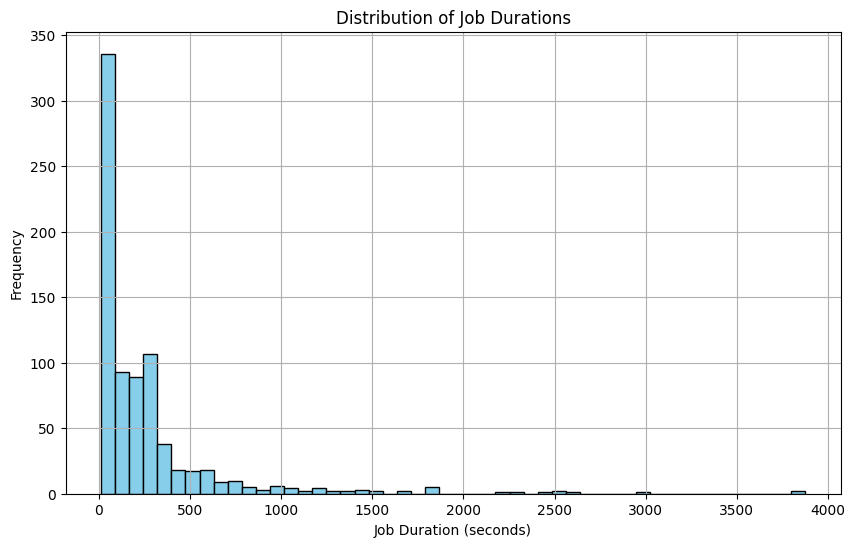

[Stage 331:>                                                        (0 + 2) / 2]

Jobs with duration > 511.85 seconds:
Job ID: 6439444426, Duration: 630.35 seconds
Job ID: 6436727905, Duration: 3875.67 seconds
Job ID: 6439468819, Duration: 827.71 seconds
Job ID: 6439488937, Duration: 615.11 seconds
Job ID: 6439489323, Duration: 572.54 seconds
Job ID: 6439493940, Duration: 808.41 seconds
Job ID: 6439496553, Duration: 2283.20 seconds
Job ID: 6439511184, Duration: 527.66 seconds
Job ID: 6439511804, Duration: 1552.64 seconds
Job ID: 6439514163, Duration: 665.30 seconds


In [79]:
from pyspark.sql import Row
import matplotlib.pyplot as plt

# File path for job events dataset
job_events_path = "./spark-project/Spark-Data-Analysis/dataset/job_events/part-00400-of-00500.csv.gz"
microseconds_to_seconds = 1e6  # Convert microseconds to seconds

# Load job events as an RDD
job_events_rdd = spark.read.option("header", "false").csv(job_events_path).rdd

# Clean and parse the RDD, ignoring null or missing values
job_events_rdd = job_events_rdd.filter(lambda record: record[0] is not None and record[2] is not None and record[3] is not None)
job_events_rdd = job_events_rdd.map(lambda record: Row(
    time=int(record[0]) / microseconds_to_seconds,  # Convert to seconds
    job_id=record[2],
    event=int(record[3])
))

# Filter for START (SCHEDULE) and FINISH events
job_start_times = job_events_rdd.filter(lambda x: x.event == 1).map(lambda x: (x.job_id, x.time))  # (job_id, start_time)
job_finish_times = job_events_rdd.filter(lambda x: x.event == 4).map(lambda x: (x.job_id, x.time))  # (job_id, finish_time)

# Join START and FINISH events by job_id to compute job duration
job_durations_rdd = job_start_times.join(job_finish_times).map(lambda x: (x[0], x[1][1] - x[1][0]))  # (job_id, duration in seconds)

# Compute average job duration across all jobs
average_job_duration_seconds = job_durations_rdd.map(lambda x: x[1]).mean()
print(f"Average job duration (seconds): {average_job_duration_seconds:.2f}")

# Collect durations for visualization
job_durations = job_durations_rdd.map(lambda x: x[1]).collect()

# Visualization: Histogram of job durations
plt.figure(figsize=(10, 6))
plt.hist(job_durations, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Job Durations')
plt.xlabel('Job Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Identify long-running jobs
threshold_seconds = average_job_duration_seconds * 2
long_running_jobs = job_durations_rdd.filter(lambda x: x[1] > threshold_seconds).collect()

# Output long-running jobs
print(f"Jobs with duration > {threshold_seconds:.2f} seconds:")
for job_id, duration in long_running_jobs[:10]:
    print(f"Job ID: {job_id}, Duration: {duration:.2f} seconds")




#### 2. Graph Analysis

The **histogram** displays the distribution of **job durations** (in seconds). 

**Key observations from the graph:**

- The majority of jobs completed in **under 500 seconds**.
- There are several **outliers** representing **longer-running jobs** that lasted for over **2000 seconds**.
- The distribution is **right-skewed**, indicating that while **most jobs finish quickly**, some jobs take **significantly longer**.

---

#### 3. Conclusion

- Most jobs have a **short duration**, but a few jobs experience **much longer runtimes**.
- Some jobs lasted for **over an hour**, indicating potential **bottlenecks** in either the **resource allocation**, **dependencies**, or **external factors**.